## Outline

**1. Get and Load data**

**2. Preprocess Data** 

**3. Analyze Data**

**4. Modeling**  

**5. Conclusion and Discussion**  

**6. Future Work**  

In [2]:
# Import libraries
import json
import gzip
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from IPython.display import display
import numpy as np
plt.style.use('ggplot')

import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
import re
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.naive_bayes import MultinomialNB
from wordcloud import STOPWORDS, WordCloud
import sklearn

%matplotlib inline
# print(plt.style.available)
print('Python version ' + sys.version)
print('Pandas version: ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)

Python version 3.6.1 |Anaconda 4.4.0 (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
Pandas version: 0.20.1
Matplotlib version 2.0.2


## ETL (Extract, Transform, Load Data)

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')
df = getDF('reviews_Movies_and_TV_5.json.gz')

In [4]:
data_ = df

In [5]:
def clean_text(string): 
    string = re.sub("[^a-zA-Z]"," ", string)
    string = string.lower() 
    return string

In [6]:
data = data_[:70000]
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4.0,good version of a classic,1203984000,"02 26, 2008"
1,A35947ZP82G7JH,0005019281,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3.0,Good but not as moving,1388361600,"12 30, 2013"
2,A3UORV8A9D5L2E,0005019281,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3.0,Winkler's Performance was ok at best!,1388361600,"12 30, 2013"
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5.0,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008"
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4.0,Best Scrooge yet,1387670400,"12 22, 2013"


In [7]:
ratings = data['overall']
data = data[data['reviewText'].isnull()==False]
reviews = map(clean_text, data['reviewText'])

In [8]:
ratings.head()

0    4.0
1    3.0
2    3.0
3    5.0
4    4.0
Name: overall, dtype: float64

## EXPLORATORY ANALYSIS

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 69999
Data columns (total 9 columns):
reviewerID        70000 non-null object
asin              70000 non-null object
reviewerName      69136 non-null object
helpful           70000 non-null object
reviewText        70000 non-null object
overall           70000 non-null float64
summary           70000 non-null object
unixReviewTime    70000 non-null int64
reviewTime        70000 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 5.3+ MB


In [10]:
data.isnull().sum()

reviewerID          0
asin                0
reviewerName      864
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
dtype: int64

We could see reviewerName has many nulls.

count    70000.00
mean         4.27
std          1.11
min          1.00
25%          4.00
50%          5.00
75%          5.00
max          5.00
Name: overall, dtype: float64


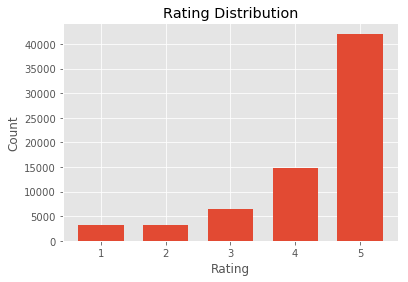

In [11]:
print(data["overall"].describe().round(2))
a=[int(i) for i in data["overall"]]
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")

count    993.00
mean       4.16
std        0.48
min        1.80
25%        3.92
50%        4.26
75%        4.51
max        5.00
Name: overall, dtype: float64


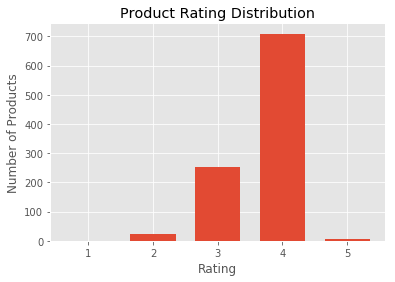

In [12]:
average_note_byproduct=data[["asin","overall"]].groupby("asin", as_index=False).mean()
print(average_note_byproduct["overall"].describe().round(2))
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(average_note_byproduct["overall"], bins=bins, align='left', rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Product Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Products")

count    33580.00
mean         2.08
std          4.13
min          1.00
25%          1.00
50%          1.00
75%          2.00
max        172.00
dtype: float64


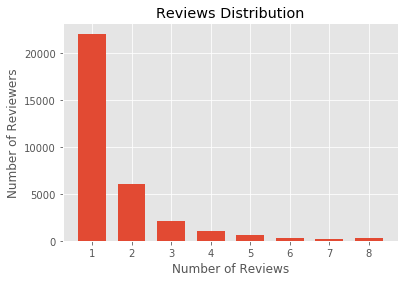

In [13]:
import collections
Nbreview_by_user=collections.Counter(data["reviewerID"])
print(pd.Series(Nbreview_by_user).describe().round(2))
bins=range(1,10,1)
a = np.clip(list(Nbreview_by_user.values()), 1, 10)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', rwidth=0.7)
plt.title("Reviews Distribution")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Reviewers")

count    70000.00
mean       167.25
std        192.78
min          0.00
25%         42.00
50%        101.00
75%        218.00
max       3505.00
Name: N_words_reviewText, dtype: float64
count    70000.00
mean         4.88
std          3.05
min          1.00
25%          3.00
50%          4.00
75%          7.00
max         26.00
Name: N_words_summary, dtype: float64


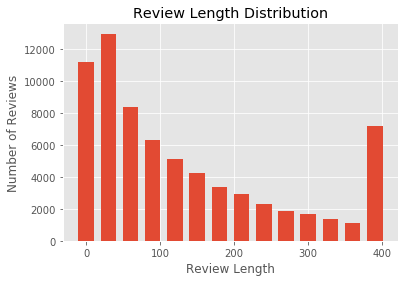

In [14]:
def countWords(review):
    return(len(review.split()))

data["N_words_reviewText"] = data["reviewText"].astype(str).apply(countWords)
print(data["N_words_reviewText"].describe().round(2))
data["N_words_summary"] = data["summary"].astype(str).apply(countWords)
print(data["N_words_summary"].describe().round(2))
bins=range(0,430,30)
a = list(np.clip(data["N_words_reviewText"], 0, 400))
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', rwidth=0.7)
plt.title("Review Length Distribution")
plt.xlabel("Review Length")
plt.ylabel("Number of Reviews")

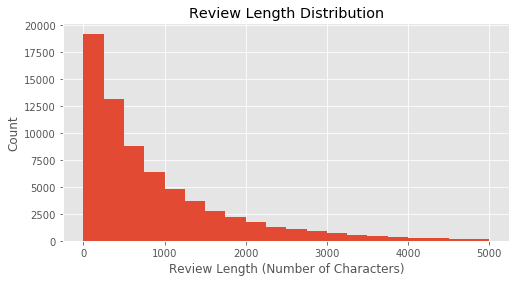

In [15]:
# Create and print a Reviews length distribution graph.
review_length_distribution_plt = pd.DataFrame(data["reviewText"].str.len())
review_length_distribution_plt = review_length_distribution_plt[review_length_distribution_plt.reviewText < 5000]
review_length_distribution_plt.groupby(["reviewText"])
review_length_distribution_plt = review_length_distribution_plt.plot(kind='hist', legend=None, bins=20, figsize=(8, 4), title="Review Length Distribution")
review_length_distribution_plt.set_xlabel("Review Length (Number of Characters)")
review_length_distribution_plt.set_ylabel("Count")

## Statistical Analysis

In [16]:
N_reviews=len(data)
N_products=len(set(data["asin"]))
N_reviewers=len(set(data["reviewerID"]))
print("The total number of reviews is: "+str(N_reviews))
print("The total number of products is: "+str(N_products))
print("Total number of reviewers: "+str(N_reviewers))
print("That's an average of "+str(round(N_reviews/N_products,1))+ " reviews per product")
print("That's an average of "+str(round(N_reviews/N_reviewers,1))+ " reviews per reviewer")

The total number of reviews is: 70000
The total number of products is: 993
Total number of reviewers: 33580
That's an average of 70.5 reviews per product
That's an average of 2.1 reviews per reviewer


## Train Data and Test Data Split

In [17]:
y = data["overall"]
X = data.drop("overall",axis=1,inplace=False)
X_train,X_test,y_train,y_test = train_test_split(X.index,y,test_size=0.25)
df_train=pd.concat([X,y],axis=1).iloc[X_train]
df_test=pd.concat([X,y],axis=1).iloc[X_test]
print(df_train.shape, df_test.shape)

(52500, 11) (17500, 11)


Train Data:
  count    52500.00
mean         4.27
std          1.11
min          1.00
25%          4.00
50%          5.00
75%          5.00
max          5.00
Name: overall, dtype: float64

Test Data:
  count    17500.00
mean         4.28
std          1.09
min          1.00
25%          4.00
50%          5.00
75%          5.00
max          5.00
Name: overall, dtype: float64


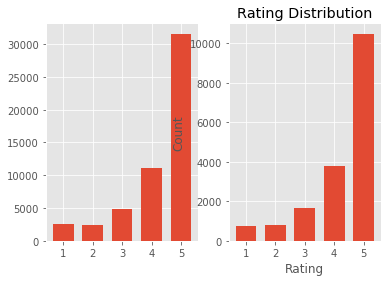

In [18]:
print('Train Data:\n ',df_train["overall"].describe().round(2))
a=[int(i) for i in df_train["overall"]]
bins=range(1,7)
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(a, bins=bins, align='left', rwidth=0.7)
ax1.set_xticks(bins[:-1])
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
print('\nTest Data:\n ', df_test["overall"].describe().round(2))
a=[int(i) for i in df_test["overall"]]
bins=range(1,7)
ax2.hist(a, bins=bins, align='left', rwidth=0.7)
ax2.set_xticks(bins[:-1])
plt.xlabel("Rating")
plt.ylabel("Count")

## Data Preprocess

Use TfidfVectorizer

In [19]:
vectorizer = TfidfVectorizer( min_df=2, max_df=0.95, ngram_range = (1,3), 
                             stop_words = 'english', max_features = 500 )

## Feature from reviewText

In [20]:
# Extract features from reviewText for X
corpus_reviewText=list(data["reviewText"].astype(str))
X_tfidf_reviewText = vectorizer.fit_transform(corpus_reviewText)
X_tfidf_reviewText.shape

(70000, 500)

## Feature from summary

In [21]:
# Extract features from summary for X
corpus_summary=list(data["summary"].astype(str))
X_tfidf_summary = vectorizer.fit_transform(corpus_summary)
X_tfidf_summary.shape

(70000, 500)

In [22]:
from sklearn.preprocessing import normalize
X_countWords=normalize(data[["N_words_reviewText","N_words_summary"]].astype(float),axis=0)
print(X_countWords.shape)

(70000, 2)


## Feature from datetime

In [23]:
from datetime import datetime
data["Month"] = data["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%m')).astype('category')
data["Month"].head()

0    02
1    12
2    12
3    02
4    12
Name: Month, dtype: category
Categories (12, object): [01, 02, 03, 04, ..., 09, 10, 11, 12]

In [24]:
data["Day"] = data["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%a')).astype('category')
data["Day"].head()

0    Mon
1    Sun
2    Sun
3    Tue
4    Sat
Name: Day, dtype: category
Categories (7, object): [Fri, Mon, Sat, Sun, Thu, Tue, Wed]

In [25]:
from sklearn.feature_extraction import DictVectorizer
dic_vec = DictVectorizer()
dic_months = pd.DataFrame(data["Month"]).to_dict('records')
X_months = dic_vec.fit_transform(dic_months)
X_months.shape

(70000, 12)

In [26]:
dic_days = pd.DataFrame(data["Day"]).to_dict('records')
X_days = dic_vec.fit_transform(dic_days)
X_days.shape

(70000, 7)

## Combine Features

In [27]:
from scipy.sparse import hstack
all_features=hstack([X_tfidf_reviewText, X_tfidf_summary, X_countWords, X_days, X_months])
all_features.shape

(70000, 1021)

In [28]:
# def get_most_relevant_phrases():
#     # Convert features into an array
#     feature_array = np.array(vectorizer.get_feature_names()) 
    
#     # Sort features by weight.
#     tfidf_sorting = np.argsort(review_features.toarray()).flatten()[::-1]
    
#     # Get the top eight most weighted features.
#     top_n = feature_array[tfidf_sorting][:8]
#     return top_n

In [29]:
X_train, X_test, y_train, y_test = train_test_split( all_features, ratings, stratify=ratings,  
                                    random_state = 0, test_size = 0.25 )

In [30]:
X_train.shape

(52500, 1021)

In [31]:
y_train.shape

(52500,)

## Modeling

Naive Bayes with multinomial model

Support Vector Machine

Decision Tree

K Neighbors

Random Forest

Logistic Regression

Logistic Regression CV

In [32]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train.astype('category'))
predicted_NaiveBayes = nb.predict(X_test)

In [33]:
from sklearn import svm
# clf = svm.LinearSVC()
clf = svm.SVC()
clf.fit(X_train, y_train.astype('category'))
predicted_SVM = clf.predict(X_test)

In [34]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train.astype('category'))
predicted_DT = dt.predict(X_test)

In [35]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train.astype('category'))
predicted_neigh = neigh.predict(X_test)

In [36]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, y_train.astype('category'))
predicted_rf = rf.predict(X_test)

In [37]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lg.fit(X_train, y_train.astype('category'))
predicted_lg = lg.predict(X_test)

In [38]:
from sklearn.linear_model import LogisticRegressionCV
lgcv = LogisticRegressionCV(multi_class='multinomial')
lgcv.fit(X_train, y_train.astype('category'))
predicted_lgcv = lgcv.predict(X_test)

## Performance Evaluation

In [39]:
model_name =["NaiveBayes","SVM", 'DecisionTree', 'KNeighbors', 'RandomForest', 
           'LogisticRegression', 'LogisticRegressionCV']
predicted = [predicted_NaiveBayes, predicted_SVM, predicted_DT, predicted_neigh,
              predicted_rf, predicted_lg, predicted_lgcv ]

def percent_round(x):
    return(str((np.mean(x)*100).round(1))+"%")

acc = [percent_round(x==y_test) for x in predicted]
acc_list = {'Accuracy' : pd.Series(acc, index=model_name)}
df_acc = pd.DataFrame(acc_list)
df_acc

,Accuracy
NaiveBayes,63.1%
SVM,64.5%
DecisionTree,49.8%
KNeighbors,51.7%
RandomForest,60.1%
LogisticRegression,64.4%
LogisticRegressionCV,64.4%


In [40]:
print("Naive Bayes Performance \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes))
print("SVM Performance \n",sklearn.metrics.classification_report(y_test, predicted_SVM))
print("Decision Tree Performance \n",sklearn.metrics.classification_report(y_test, predicted_DT))
print("KNeighbors Performance \n",sklearn.metrics.classification_report(y_test, predicted_neigh))
print("RandomForest Performance \n",sklearn.metrics.classification_report(y_test, predicted_rf))
print("LogisticRegression Performance \n",sklearn.metrics.classification_report(y_test, predicted_lg))
print("LogisticRegressionCV \n",sklearn.metrics.classification_report(y_test, predicted_lgcv))

Naive Bayes Performance 
              precision    recall  f1-score   support

        1.0       0.63      0.21      0.31       820
        2.0       0.47      0.05      0.08       813
        3.0       0.42      0.09      0.15      1635
        4.0       0.43      0.16      0.24      3712
        5.0       0.66      0.96      0.78     10520

avg / total       0.58      0.63      0.55     17500

SVM Performance 
              precision    recall  f1-score   support

        1.0       0.54      0.37      0.44       820
        2.0       0.38      0.06      0.11       813
        3.0       0.41      0.13      0.19      1635
        4.0       0.42      0.22      0.29      3712
        5.0       0.69      0.94      0.80     10520

avg / total       0.59      0.65      0.58     17500

Decision Tree Performance 
              precision    recall  f1-score   support

        1.0       0.19      0.18      0.18       820
        2.0       0.08      0.08      0.08       813
        3.0       0.

/Users/yuleinku/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Transform Multinomial to Binary Problem

In [41]:
def bin_transformation(x):
    if (x==5 or x==4):
        return("1")
    else:
        return("0")

y_train_bin=y_train.apply(bin_transformation).astype("category")
y_test_bin=y_test.apply(bin_transformation).astype("category")

In [42]:
nb.fit(X_train, y_train_bin)
predicted_bin_NaiveBayes = nb.predict(X_test)

clf.fit(X_train, y_train_bin)
predicted_bin_SVM = clf.predict(X_test)

dt.fit(X_train, y_train_bin)
predicted_bin_DT = dt.predict(X_test)

neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train_bin)
predicted_bin_neigh = neigh.predict(X_test)

rf.fit(X_train, y_train_bin)
predicted_bin_rf = rf.predict(X_test)

lg.fit(X_train, y_train_bin)
predicted_bin_lg = lg.predict(X_test)

lgcv.fit(X_train, y_train_bin)
predicted_bin_lgcv = lgcv.predict(X_test)


## Now we can re-evaluate all the classifiers on our features. Note that the Precision, Recall and f1-score indicators are calculated for the '4' and '5' labels only because the problem is binary.

In [43]:
predicted_bin = [predicted_bin_NaiveBayes, predicted_bin_SVM, predicted_bin_DT, predicted_bin_neigh,
              predicted_bin_rf, predicted_bin_lg, predicted_bin_lgcv ]

def percent_round1(x):
    return(str((x*100).round(1))+ "%")

Accuracy_bin = [percent_round1(np.mean(x==y_test_bin)) for x in predicted_bin]
Report_bin = [sklearn.metrics.precision_recall_fscore_support(y_test_bin, x) for x in predicted_bin]
Precision_bin = [percent_round1(x[0][1]) for x in Report_bin]
Recall_bin = [percent_round1(x[1][1]) for x in Report_bin]
f1score_bin = [percent_round1(x[2][1]) for x in Report_bin]
result_bin = {'Accuracy' : pd.Series(Accuracy_bin, index=model_name),
           'Precision' : pd.Series(Precision_bin, index=model_name),
           'Recall' : pd.Series(Recall_bin, index=model_name),
           'f1-score': pd.Series(f1score_bin, index=model_name),
           }
df_bin = pd.DataFrame(result_bin)
df_bin

/Users/yuleinku/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall,f1-score
NaiveBayes,84.1%,84.5%,98.5%,91.0%
SVM,85.9%,87.4%,96.6%,91.8%
DecisionTree,76.4%,85.3%,85.7%,85.5%
KNeighbors,64.7%,85.4%,68.3%,75.9%
RandomForest,81.3%,81.3%,100.0%,89.7%
LogisticRegression,85.7%,87.7%,95.9%,91.6%
LogisticRegressionCV,84.1%,83.9%,99.5%,91.1%


In [45]:
nb.fit(X_train, y_train_bin)
probas_bin_NaiveBayes = nb.predict_proba(X_test)[:,1]

clf.fit(X_train, y_train_bin)
probas_bin_SVM = nb.predict_proba(X_test)[:,1]

# dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train_bin)
probas_bin_DT = dt.predict_proba(X_test)[:,1]

# neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train_bin)
probas_bin_neigh = neigh.predict_proba(X_test)[:,1]

# rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, y_train_bin)
probas_bin_rf = rf.predict_proba(X_test)[:,1]

# lg = LogisticRegression()
lg.fit(X_train, y_train_bin)
probas_bin_lg = lg.predict_proba(X_test)[:,1]

# lgcv = LogisticRegressionCV()
lgcv.fit(X_train, y_train_bin)
probas_bin_lgcv = lgcv.predict_proba(X_test)[:,1]

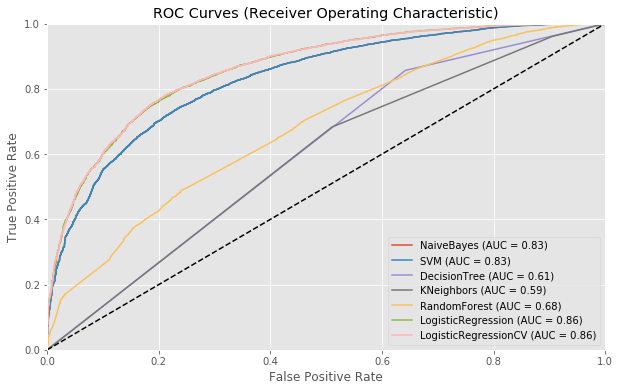

In [46]:
from sklearn.metrics import roc_curve, auc
matplotlib.rcParams['figure.figsize'] = (10, 6)

probas=[probas_bin_NaiveBayes, probas_bin_SVM, probas_bin_DT, probas_bin_neigh,
              probas_bin_rf, probas_bin_lg, probas_bin_lgcv ]

fpr= [None] * len(probas)
tpr=[None] * len(probas)
thresholds=[None] * len(probas)
roc_auc=[None] * len(probas)
for i in range(len(probas)):
    fpr[i], tpr[i], thresholds[i] = sklearn.metrics.roc_curve(y_test_bin.ravel().astype(float), probas[i], pos_label=1.0)
    roc_auc[i]=auc(fpr[i],tpr[i])
    plt.plot(fpr[i], tpr[i], label=model_name[i]+" (AUC = %0.2f)" % roc_auc[i])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Receiver Operating Characteristic)')
plt.legend(loc="lower right")           

## NB hyper-parameters Optimization for binary classification

In [47]:
from sklearn import grid_search
parameters_NB = {'alpha':list(np.linspace(0.001,10,50))}
nb = grid_search.GridSearchCV(MultinomialNB(), parameters_NB)
nb.fit(X_train, y_train_bin)

best_parameters, score, _ = max(nb.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters_NB.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

alpha: 0.001


## SVM hyper-parameters Optimization for binary classification

In [49]:
parameters_SVM = {'alpha':list(np.linspace(0.000001,0.001,50)),
                  'loss':["modified_huber","log"],
                  'penalty': ["l1", "l2","elasticnet"],
                  }
svm = grid_search.GridSearchCV(SGDClassifier(), parameters_SVM)
svm.fit(X_train, y_train_bin)

best_parameters, score, _ = max(svm.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters_SVM.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

alpha: 4.1775510204081632e-05
loss: 'log'
penalty: 'elasticnet'


# Prediction on optimized models

In [50]:
predicted_bin_NaiveBayes_optim = nb.predict(X_test)
predicted_bin_SVM_optim = svm.predict(X_test)

## Conclusion And Discussion

In [51]:
index_clf=["NaiveBayes_Normal",'NaiveBayes_Optimized', "SVM_Normal", 'SVM_Optimized',
           'DecisionTree', 'KNeighbors', 'RandomForest', 
           'LogisticRegression', 'LogisticRegressionCV']
predicted_clf=[predicted_bin_NaiveBayes,predicted_bin_NaiveBayes_optim, predicted_bin_SVM, 
               predicted_bin_SVM_optim, predicted_bin_DT, predicted_bin_neigh,
              predicted_bin_rf, predicted_bin_lg, predicted_bin_lgcv ]

def percent_round1(x):
    return(str((x*100).round(1))+ "%")

Accuracy_clf=[percent_round1(np.mean(x==y_test_bin)) for x in predicted_clf]
Report_clf=[sklearn.metrics.precision_recall_fscore_support(y_test_bin, x) for x in predicted_clf]
Precision_clf=[percent_round1(x[0][1]) for x in Report_clf]
Recall_clf=[percent_round1(x[1][1]) for x in Report_clf]
f1score_clf=[percent_round1(x[2][1]) for x in Report_clf]
dic_clf = {'Accuracy' : pd.Series(Accuracy_clf, index=index_clf),
           'Precision' : pd.Series(Precision_clf, index=index_clf),
           'Recall' : pd.Series(Recall_clf, index=index_clf),
           'f1-score': pd.Series(f1score_clf, index=index_clf),
            }
df_clf=pd.DataFrame(dic_clf)
df_clf    

/Users/yuleinku/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall,f1-score
NaiveBayes_Normal,84.1%,84.5%,98.5%,91.0%
NaiveBayes_Optimized,84.1%,84.6%,98.4%,91.0%
SVM_Normal,85.9%,87.4%,96.6%,91.8%
SVM_Optimized,85.7%,87.0%,96.9%,91.7%
DecisionTree,76.4%,85.3%,85.7%,85.5%
KNeighbors,64.7%,85.4%,68.3%,75.9%
RandomForest,81.3%,81.3%,100.0%,89.7%
LogisticRegression,85.7%,87.7%,95.9%,91.6%
LogisticRegressionCV,84.1%,83.9%,99.5%,91.1%


# Total 9 variables

4 Used:

overall, reveiwText, summary, unixReviewTime

2 Droped: 

reviewerName (missing)

reviewTime (already used unixReviewTime)

3 future useful: 

reviewerID, asin, helpful

## Future Work

1. Use reviewerID, asin, helpful
2. Time Series
3. Deep Learning (use word2vec, RNN, LSTM)